In [1]:
import ultralytics
import torch

**M1칩 내 GPU 사용 가능 여부 확인**

In [13]:
print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

PyTorch version: 2.2.2
MPS available: True
MPS built: True


**KITTI 라벨을 YOLO에서 사용하는 형식으로 바꾸기**

In [1]:
import os
import cv2
from tqdm.auto import tqdm  # 맨 위 import들 옆에 추가

# ----- 경로 설정 -----
IMG_DIR = "data_object_image_2/training/image_2"
LBL_DIR = "training/label_2"

OUT_IMG = "kitti/images_yolo"      # YOLO 이미지 저장
OUT_LBL = "kitti/labels_yolo"      # YOLO 라벨 저장

os.makedirs(OUT_IMG, exist_ok=True)
os.makedirs(OUT_LBL, exist_ok=True)


In [2]:

# ----- 클래스 매핑  -----
def map_class(name: str):
    name = name.lower()

    # 차량 계열
    if name in ["car", "van", "truck"]:
        return 0

    # 보행자
    if name in ["pedestrian"]:
        return 1

    # 이륜차
    if name in ["cyclist"]:
        return 2

    # 제거할 클래스들
    if name in ["person_sitting", "dontcare", "misc", "tram"]:
        return None

    # 그 외도 전부 무시
    return None


# ----- 변환 함수 -----
def convert_kitti_to_yolo(img_name):
    img_path = os.path.join(IMG_DIR, img_name)
    label_name = img_name.replace(".png", ".txt").replace(".jpg", ".txt")
    label_path = os.path.join(LBL_DIR, label_name)

    img = cv2.imread(img_path)
    if img is None:
        return

    h, w = img.shape[:2]
    yolo_lines = []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls_name = parts[0]

                cls_id = map_class(cls_name)
                if cls_id is None:
                    continue

                xmin = float(parts[4])
                ymin = float(parts[5])
                xmax = float(parts[6])
                ymax = float(parts[7])

                x_center = ((xmin + xmax) / 2) / w
                y_center = ((ymin + ymax) / 2) / h
                bw = (xmax - xmin) / w
                bh = (ymax - ymin) / h

                if bw <= 0 or bh <= 0:
                    continue

                yolo_lines.append(f"{cls_id} {x_center} {y_center} {bw} {bh}\n")

    # 저장
    out_img_path = os.path.join(OUT_IMG, img_name)
    out_lbl_path = os.path.join(OUT_LBL, label_name)

    cv2.imwrite(out_img_path, img)
    with open(out_lbl_path, "w") as f:
        f.writelines(yolo_lines)


# 파일 목록
files = sorted([f for f in os.listdir(IMG_DIR)
                if f.endswith(".png") or f.endswith(".jpg")])

# 🔥 tqdm으로 진행률 표시
for name in tqdm(files, desc="Converting KITTI → YOLO"):
    convert_kitti_to_yolo(name)

print("KITTI → YOLO 변환 완료!")

Converting KITTI → YOLO:   0%|          | 0/7481 [00:00<?, ?it/s]

KITTI → YOLO 변환 완료!


**라벨 변환이 잘 되었는지 실제 이미지에 박스 그려서 확인하는 시각화**

In [16]:
import os
import random
import cv2
from IPython.display import Image, display

# YOLO 변환된 파일이 저장된 폴더
YOLO_IMG_DIR = "kitti/images_yolo"
YOLO_LBL_DIR = "kitti/labels_yolo"

# class_id → 클래스명 매핑
CLASS_NAMES = {
    0: "vehicle",
    1: "pedestrian",
    2: "two_wheeler"
}

선택된 이미지: 006353.png
YOLO 라벨 파일: kitti/labels_yolo/006353.txt
시각화 이미지 저장됨: yolo_debug.png


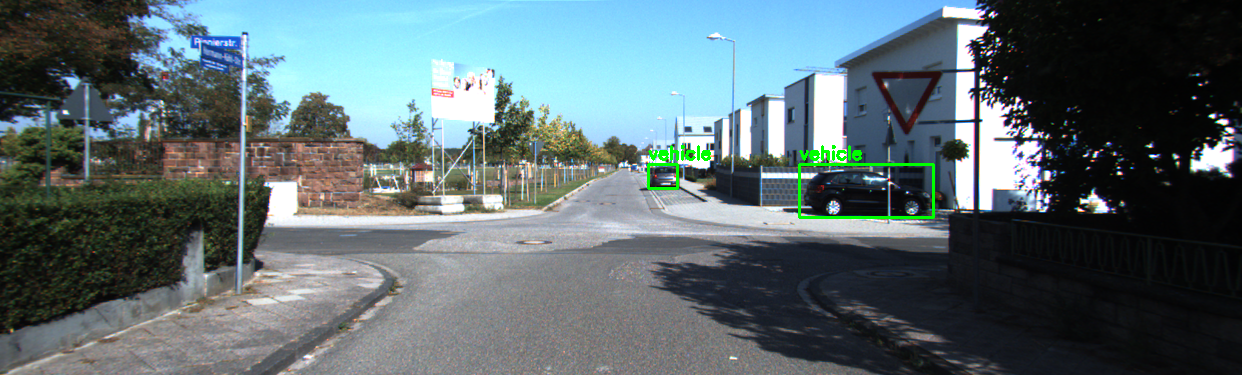

In [7]:
def visualize_yolo_label():
    # YOLO 이미지 목록
    img_files = [f for f in os.listdir(YOLO_IMG_DIR)
                 if f.endswith(".png") or f.endswith(".jpg")]

    if not img_files:
        print("YOLO 이미지 폴더가 비어 있습니다:", YOLO_IMG_DIR)
        return
    
    # 랜덤 이미지 선택
    img_name = random.choice(img_files)
    img_path = os.path.join(YOLO_IMG_DIR, img_name)

    label_name = img_name.rsplit(".", 1)[0] + ".txt"
    label_path = os.path.join(YOLO_LBL_DIR, label_name)

    print("선택된 이미지:", img_name)
    print("YOLO 라벨 파일:", label_path)

    # 이미지 읽기
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # 라벨 읽기
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                bw = float(parts[3])
                bh = float(parts[4])

                # YOLO 포맷 → 픽셀 좌표 변환
                box_w = bw * w
                box_h = bh * h
                cx = x_center * w
                cy = y_center * h

                xmin = int(cx - box_w / 2)
                ymin = int(cy - box_h / 2)
                xmax = int(cx + box_w / 2)
                ymax = int(cy + box_h / 2)

                # 박스 그리기
                color = (0, 255, 0)
                cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), color, 2)

                cls_name = CLASS_NAMES.get(cls_id, str(cls_id))
                cv2.putText(
                    img_rgb,
                    cls_name,
                    (xmin, max(0, ymin - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    color,
                    2
                )

    else:
        print("라벨 파일이 없습니다:", label_path)

    # 이미지 저장 후 출력
    out_path = "yolo_debug.png"
    cv2.imwrite(out_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))

    print("시각화 이미지 저장됨:", out_path)
    display(Image(filename=out_path))


# 실행
visualize_yolo_label()

**Train과 Validation 데이터 6:4로 분리**

In [3]:
import os
import shutil
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

BASE_DIR = "kitti"
IMG_ROOT = os.path.join(BASE_DIR, "images_yolo")   # 전체 YOLO 이미지
LBL_ROOT = os.path.join(BASE_DIR, "labels_yolo")   # 전체 YOLO 라벨

IMG_TRAIN = os.path.join(IMG_ROOT, "train")
IMG_VAL   = os.path.join(IMG_ROOT, "val")
LBL_TRAIN = os.path.join(LBL_ROOT, "train")
LBL_VAL   = os.path.join(LBL_ROOT, "val")

os.makedirs(IMG_TRAIN, exist_ok=True)
os.makedirs(IMG_VAL, exist_ok=True)
os.makedirs(LBL_TRAIN, exist_ok=True)
os.makedirs(LBL_VAL, exist_ok=True)

# 1️⃣ 루트(images_yolo) 바로 아래에 있는 이미지 파일만 대상 (train/val 폴더 제외)
all_imgs = [
    f for f in os.listdir(IMG_ROOT)
    if f.lower().endswith((".png", ".jpg"))
       and os.path.isfile(os.path.join(IMG_ROOT, f))
]

print("전체 YOLO 이미지 수:", len(all_imgs))

# 2️⃣ scikit-learn으로 6:4 split
train_files, val_files = train_test_split(
    all_imgs,
    test_size=0.4,
    random_state=42,
    shuffle=True
)

print("train 이미지:", len(train_files), " / val 이미지:", len(val_files))

# 3️⃣ 이미지-라벨 세트 이동 함수
def move_pair(img_name, dst_img_dir, dst_lbl_dir):
    base = os.path.splitext(img_name)[0]

    src_img = os.path.join(IMG_ROOT, img_name)
    src_lbl = os.path.join(LBL_ROOT, base + ".txt")

    dst_img = os.path.join(dst_img_dir, img_name)
    dst_lbl = os.path.join(dst_lbl_dir, base + ".txt")

    # 이미지 이동
    shutil.move(src_img, dst_img)

    # 라벨이 있으면 같이 이동
    if os.path.exists(src_lbl):
        shutil.move(src_lbl, dst_lbl)

# 4️⃣ tqdm으로 진행률 보면서 이동
print("\n📦 Train 세트로 이동 중...")
for name in tqdm(train_files, desc="Train split"):
    move_pair(name, IMG_TRAIN, LBL_TRAIN)

print("\n📦 Validation 세트로 이동 중...")
for name in tqdm(val_files, desc="Val split"):
    move_pair(name, IMG_VAL, LBL_VAL)

# 5️⃣ 최종 개수 확인
num_img_train = len([f for f in os.listdir(IMG_TRAIN) if f.lower().endswith((".png", ".jpg"))])
num_img_val   = len([f for f in os.listdir(IMG_VAL)   if f.lower().endswith((".png", ".jpg"))])
num_lbl_train = len([f for f in os.listdir(LBL_TRAIN) if f.endswith(".txt")])
num_lbl_val   = len([f for f in os.listdir(LBL_VAL)   if f.endswith(".txt")])

print("\n✅ 분리 완료!")
print("images_yolo/train 이미지 수:", num_img_train)
print("images_yolo/val   이미지 수:", num_img_val)
print("labels_yolo/train 라벨 수  :", num_lbl_train)
print("labels_yolo/val   라벨 수  :", num_lbl_val)


이미지 총 개수: 7481
train: 4488  / val: 2993

Train 데이터 이동


  0%|          | 0/4488 [00:00<?, ?it/s]


Validation 데이터 이동


  0%|          | 0/2993 [00:00<?, ?it/s]


완료!
train 이미지: 6281
val   이미지: 4786
train 라벨: 6281
val   라벨: 4787


**YAML파일 생성**

In [4]:
yaml_text = """train: kitti/images_yolo/train
val: kitti/images_yolo/val

nc: 3
names: ["vehicle", "pedestrian", "two_wheeler"]
"""

yaml_path = "kitti.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_text)

print("kitti.yaml 생성 완료 →", os.path.abspath(yaml_path))
print("내용:")
print(yaml_text)


kitti.yaml 생성 완료 → /Users/jihyunsmac/Desktop/팀_프로젝트/project1/kitti.yaml
내용:
train: kitti/images_yolo/train
val: kitti/images_yolo/val

nc: 3
names: ["vehicle", "pedestrian", "two_wheeler"]



**모델 학습 (yolon11n.pt)**

In [ ]:
from ultralytics import YOLO

# 1. 사전학습된 작은 모델 로드 (처음에는 yolo11n 권장)
model = YOLO("yolo11n.pt")

# 2. 학습 (지금 환경에서 너무 무리한 옵션이라 터미널에서 다시 시도해볼 예정)
results = model.train(
    data="kitti.yaml",   # 방금 만든 yaml
    epochs=50,           # 상황에 맞게 조절 가능
    imgsz=640,
    batch=8,             # M1 메모리 보고 조정 (작으면 4, 2로 줄이기)
    device="mps"         # ⭐ M1 GPU 사용
)


#nvidia gpu 사용시
#model.train(
#    data="kitti.yaml",
#    epochs=50,
#    imgsz=640,
#    batch=8,
#    device="cuda"  # 또는 device=0 (첫 번째 GPU)
#s)

print("학습 완료!")


Ultralytics 8.3.232 🚀 Python-3.8.10 torch-2.2.2 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kitti.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, pr

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


YOLO11n summary: 181 layers, 2,590,425 parameters, 2,590,409 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.1±0.0 ms, read: 775.3±161.0 MB/s, size: 762.0 KB)
train: Scanning /Users/jihyunsmac/Desktop/팀_프로젝트/project1/kitti/images_yolo/train.cache... 0 images, 6281 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6281/6281 4.7Mit/s 0.0s0s
WARNING ⚠️ Labels are missing or empty in /Users/jihyunsmac/Desktop/팀_프로젝트/project1/kitti/images_yolo/train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 769.1±147.9 MB/s, size: 759.7 KB)
val: Scanning /Users/jihyunsmac/Desktop/팀_프로젝트/project1/kitti/images_yolo/val.cache... 0 images, 4786 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4786/4786 4.1Mit/s 0.0s0s
WARNING ⚠️ Labels are missing or empty in /Users/jihyunsmac/Deskto

**mAP 측정 + 예측 시각화**

In [5]:
# best.pt 불러오기 (학습 후 자동 저장된 가중치)
best_model = YOLO("runs/detect/train/weights/best.pt")  # 실제 경로는 로그에 나오는 이름 확인

val_results = best_model.val(device="mps")
print("mAP50-95:", val_results.box.map)   # 전체 mAP
print("클래스별 mAP:", val_results.box.maps)

#nvidia gpu를 사용할 경우
#best_model.predict(source=img, device="cuda")
#best_model.val(device="cuda")


FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train/weights/best.pt'

**bounding box 시각화**

In [ ]:
from IPython.display import Image, display
import glob
import random
import os

# validation 이미지 중 하나 고르기
val_imgs = glob.glob("kitti/images_yolo/val/*.png") + glob.glob("kitti/images_yolo/val/*.jpg")
sample_img = random.choice(val_imgs)
print("샘플 이미지:", sample_img)

# 예측 (이미지 저장)
pred_results = best_model.predict(
    source=sample_img,
    device="mps",
    save=True
)

# YOLO가 저장한 이미지 경로 찾기
save_dir = pred_results[0].save_dir  # runs/detect/predict 또는 비슷한 경로
saved_files = list(save_dir.glob("*"))  # Path 객체라면
print("저장 경로:", save_dir)

# 이미지 표시
for f in saved_files:
    if f.suffix.lower() in [".png", ".jpg", ".jpeg"]:
        display(Image(filename=str(f)))
        break


**fps 측정 코드**

In [ ]:
import time

# 검증용 이미지 하나 선택
img = random.choice(val_imgs)
print("FPS 측정용 이미지:", img)

# 워밍업
_ = best_model.predict(source=img, device="mps", verbose=False)

N = 50
start = time.time()
for _ in range(N):
    _ = best_model.predict(source=img, device="mps", verbose=False)
end = time.time()

fps = N / (end - start)
print(f"추론 FPS: {fps:.2f}")
